# Introduction
In this tutorial, we will see how one can use `audtorch` to rapidly speed up the development of audio-based deep learning applications.

## Preliminaries

* [PyTorch](https://pytorch.org/) already has an inteface for data sets, aptly called [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) 
* It then wraps this interface with a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) that efficiently allows us to loop through the data in parallel, and takes care of the random order as well
* All we need to do is implement the [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) interface to get the input for the model and the labels
* **However**, it is not easy for beginners to see how one can go from a bunch of files in their hard drive, to the features that will be used as input in a machine learning model
* **Thankfully**, `audtorch` is there to take of all that for you :-)

Before you start, you might want to familiarize yourselves with [PyTorch's data pipeline](https://pytorch.org/docs/stable/data.html)

## Data loading
We are going to start with loading the necessary data.  

`audtorch` offers a growing [collection of data sets](https://audtorch.readthedocs.io/en/latest/api-datasets.html). Normally, using this interface requires one to have that particular data set on their hard drive. Some of them even support downloading from their original source.  

We will be using the Berlin Database of Emotional Speech (EmoDB) for this tutorial. For convenience, we have included two of its files in a sub-directory. We recommend you to get the whole data base from its [original website ](http://www.emodb.bilderbar.info/navi.html).  

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import audtorch
import IPython.display as ipd

In [2]:
dataset = audtorch.datasets.EmoDB(
    root='data/emodb'
)
print(dataset)

Dataset EmoDB
    Number of data points: 2
    Root Location: /media/atriant/Secure/PublicDev/audtorch/docs/tutorials/data/emodb
    Sampling Rate: 16000Hz
    Labels: emotion



In [3]:
x, y = dataset[0]
print(x.shape)
print(y)

(1, 35023)
E


In [4]:
ipd.Audio(x, rate=dataset.sampling_rate)

That's it really. Up to this point, `audtorch` does not add much to the PyTorch's data API, which is already quite advanced anyway.

## Feature extraction
Feature extraction is the first important benefit of using `audtorch`.  

`audtorch` collects an ever growing set of [feature transformation and data pre-processing utilities](https://audtorch.readthedocs.io/en/latest/api-transforms.html#). That way you don't need to worry too much about getting your data pipeline ready, but you can quickly start with the cool modelling part.  

A typical kind of features used in the audio domain, are spectral features. Audio signals are analyzed with respect to their frequency content using something called a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform).  

Moreover, since that content changes over time, we normally use a [short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform). This leads then to the generation of a so-called [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which is nothing more than an image representation of the frequency content of a signal over time.  

We assume that the reader is already familiar with this terminology. What's important to point out, is that `audtorch` is designed to allow for easy usage of those features in a typical `PyTorch` workflow. Below, we see an example of how a feature extraction transform is defined:

In [5]:
spec = audtorch.transforms.Spectrogram(
    window_size=int(0.025 * dataset.sampling_rate),
    hop_size=int(0.010 * dataset.sampling_rate)
)
print(spec)

Spectrogram(window_size=400, hop_size=160, axis=-1)


By plotting the spectrogram, we see what frequency content our signal has over time.

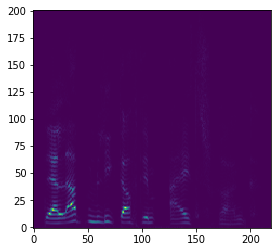

In [6]:
spectrogram = spec(x)
plt.imshow(spectrogram.squeeze())
plt.gca().invert_yaxis()

The above image looks mostly empty. That's why we have a lot of content with very low power that is dominated by the presence of a few frequencies where most of the signal's power is concentrated.  

It is typical to compute the logarithm of the spectrogram to reveal more information. That squashes the input and reveals previously hidden structure in other frequency bands. Incidentally, this squashing reduces the dynamic range of the resulting image, which makes our input more suitable for deep neural network training.  

`audtorch` provides a nice wrapper function for [numpy's log](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) to simplify things.

In [7]:
lg = audtorch.transforms.Log()
print(lg)

Log(magnitude_boost=1e-07)


In [8]:
log_spectrogram = lg(spectrogram)

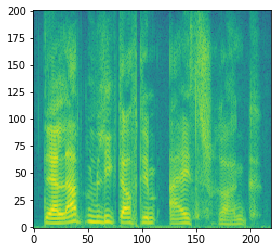

In [9]:
plt.imshow(log_spectrogram.squeeze())
plt.gca().invert_yaxis()

This image shows that there is a lot more going on in our signal than we previously thought. 

In general, we recommend to always start with a preliminary data analysis before you jump into modelling to ensure you have the proper understanding of your problem.  

`audtorch` is here to help you with that, and another useful feature is that it allows you to stack multiple transforms in a [Compose transform](https://audtorch.readthedocs.io/en/latest/api-transforms.html#audtorch.transforms.Compose). Below, we stack together the spectrogram and the log transforms to form a single object.

In [10]:
t = audtorch.transforms.Compose(
    [
        audtorch.transforms.Spectrogram(
            window_size=int(0.025 * 16000),
            hop_size=int(0.010 * 16000)
        ),
        audtorch.transforms.Log()
    ]
)
print(t)

Compose(
    Spectrogram(window_size=400, hop_size=160, axis=-1)
    Log(magnitude_boost=1e-07)
)


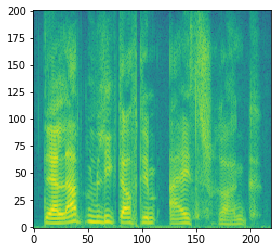

In [11]:
plt.imshow(t(x).squeeze())
plt.gca().invert_yaxis()

This stacking can continue *ad infinum*, as seen below with the [Standardize transform](https://audtorch.readthedocs.io/en/latest/api-transforms.html#standardize).  

Make sure to always stay up to date with [all the transforms offered by audtorch](https://audtorch.readthedocs.io/en/latest/api-transforms.html)!

In [12]:
t = audtorch.transforms.Compose(
    [
        audtorch.transforms.Spectrogram(
            window_size=int(0.025 * 16000),
            hop_size=int(0.010 * 16000)
        ),
        audtorch.transforms.Log(),
        audtorch.transforms.Standardize()
    ]
)
print(t)

Compose(
    Spectrogram(window_size=400, hop_size=160, axis=-1)
    Log(magnitude_boost=1e-07)
    Standardize(axis=-1, mean=True, std=True)
)


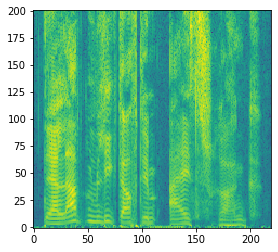

In [13]:
plt.imshow(t(x).squeeze())
plt.gca().invert_yaxis()

## Data augmentation

One of the most crucial aspects of recent deep learning successes is arguably data augmentation. Roughly, this means increasing the sampling of your input space by creating slightly different copies of the original input without changing the label.  

In the image domain, people use a variety of transforms, such as:

* Adding noise
* Cropping
* Rotating
* Etc.

Things are not so easy in the audio domain. Rotation, for example, does not make any sense for spectrogram features, since the two axes are not interchangeable. In general, the community seems to use the following transforms:

* Noise
* Time/frequency masking
* Pitch shifting
* Etc.

An important feature of `audtorch` is making these transformations very easy to use in practice. In the following example, we will be using [RandomAdditiveMix](https://audtorch.readthedocs.io/en/latest/api-transforms.html#randomadditivemix). This transforms allows you to randomly mix audio samples with a noise data set of your choice (e.g. a large audio data set like [AudioSet](https://audtorch.readthedocs.io/en/latest/api-datasets.html#audioset)).  

In this example, we will use a built-in data set, [WhiteNoise](https://audtorch.readthedocs.io/en/latest/api-datasets.html#whitenoise), which simply creates a random white noise signal every time it is called.

In [14]:
random_mix = audtorch.transforms.RandomAdditiveMix(
    dataset=audtorch.datasets.WhiteNoise(sampling_rate=dataset.sampling_rate)
)
print(random_mix)

RandomAdditiveMix(dataset=WhiteNoise, ratios=[0, 15, 30], ratio=None, percentage_silence=0, expand_method=pad, crop_method=random, time_axis=-1, channel_axis=-2)


You can see that this transforms modifies the audio signal itself, by adding this "static" TV noise to our original signal. Obviously though, the emotion of the speaker remains the same. This is a very practical way to augment your training set without changing the labels.

In [15]:
import IPython.display as ipd
ipd.Audio(random_mix(x), rate=dataset.sampling_rate)

### Stacking data augmentation and feature extraction
What is really important, is that `audtorch` allows us to do simultaneous data augmentation and feature extraction **on-the-fly**.  

This is very useful in the typical case where we run the same training samples multiple times through the network (i.e. when we train for multiple epochs), and would like to slightly change the input every time. All we have to do is stack our data augmentation transforms on top of our feature extraction ones.

In [16]:
t = audtorch.transforms.Compose(
    [
        audtorch.transforms.RandomAdditiveMix(
            dataset=audtorch.datasets.WhiteNoise(sampling_rate=dataset.sampling_rate),
            expand_method='multiple'
        ),
        audtorch.transforms.Spectrogram(
            window_size=int(0.025 * dataset.sampling_rate),
            hop_size=int(0.010 * dataset.sampling_rate)
        ),
        audtorch.transforms.Log(),
        audtorch.transforms.Standardize()
    ]
)
print(t)

Compose(
    RandomAdditiveMix(dataset=WhiteNoise, ratios=[0, 15, 30], ratio=None, percentage_silence=0, expand_method=multiple, crop_method=random, time_axis=-1, channel_axis=-2)
    Spectrogram(window_size=400, hop_size=160, axis=-1)
    Log(magnitude_boost=1e-07)
    Standardize(axis=-1, mean=True, std=True)
)


We can clearly see how this spectrogram seems noisier than the one we had before. Hopefully, this will be enough to make our classifier generalize better!

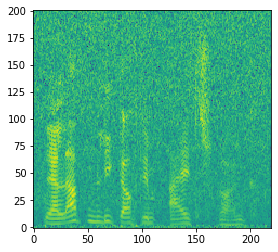

In [17]:
plt.imshow(t(x).squeeze())
plt.gca().invert_yaxis()